# Shipping & Marine — Data cleaning and EDA

This notebook focuses on marine and shipping-related series from the provided Statistics Canada table (23100269).

We will: load the CSV, extract 'mode' and 'destination' (keep destinations), classify non-marine modes as 'Others', aggregate TEU / marine measures by month and destination, produce a quick time-series plot, and save a shipping-focused cleaned CSV.

In [1]:
# Imports and display settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set(style="whitegrid")
DATA_PATH = Path("23100269.csv")
assert DATA_PATH.exists(), f"Data file not found: {DATA_PATH}"
print('Imports ready — data path:', DATA_PATH)

Imports ready — data path: 23100269.csv


In [2]:
# Load the CSV and basic cleaning
df = pd.read_csv(DATA_PATH)
# REF_DATE values are like '2017-01' — convert to period / datetime (month start)
df['REF_DATE'] = pd.to_datetime(df['REF_DATE'].astype(str), format='%Y-%m')
# Ensure VALUE is numeric where possible
df['VALUE'] = pd.to_numeric(df['VALUE'], errors='coerce')
# Short preview
print('Rows loaded:', len(df))
df.head()

Rows loaded: 3441


,REF_DATE,GEO,DGUID,Activity indicators,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2017-01-01,Canada,2016A000011124,"International passengers, number of Canadian a...",Number,223,thousands,3,v1061874463,1.1,4215.0,NaN,NaN,NaN,0
1,2017-01-01,Canada,2016A000011124,By automobile,Number,223,thousands,3,v1061874464,1.2,3032.0,NaN,NaN,NaN,0
2,2017-01-01,Canada,2016A000011124,By plane,Number,223,thousands,3,v1061874465,1.3,1055.0,NaN,NaN,NaN,0
3,2017-01-01,Canada,2016A000011124,"By boat, bus, rail and other modes of transpor...",Number,223,thousands,3,v1061874466,1.4,128.0,NaN,NaN,NaN,0
4,2017-01-01,Canada,2016A000011124,"International passengers, number of Canadian a...",Number,223,thousands,3,v1061874467,1.5,1675.0,NaN,NaN,NaN,0


In [3]:
# Extract mode and destination from 'Activity indicators'
act = df['Activity indicators'].astype(str)
# Mode detection: Marine, TEU/container (shipping-specific), else Others
mode_conditions = [
    act.str.contains('Marine', case=False, na=False),
    act.str.contains('Twenty feet|TEU|container', case=False, na=False)
]
mode_choices = ['Marine', 'TEU']
df['mode'] = np.select(mode_conditions, mode_choices, default='Others')
# Destination/direction extraction
# Look for patterns like 'to the United States' / 'from the rest of world'
dest_extract = act.str.extract('(?i)\\b(to|from) the (United States|rest of world)\\b', expand=True)
df['direction'] = dest_extract[0].str.lower().map({'to':'To','from':'From'})
df['dest_base'] = dest_extract[1].str.title().replace({np.nan: None})
# Compose a destination label when direction exists
df['destination'] = df.apply(lambda r: f"{r['direction']} {r['dest_base']}" if pd.notna(r['direction']) and pd.notna(r['dest_base']) else None, axis=1)
# For some shipping TEU series the 'Activity indicators' may not include 'to/from' — set sensible fallbacks:
# - If UOM indicates 'Twenty feet equivalent units' and name contains 'Export'/'Import', keep those labels;
uom = df['UOM'].astype(str).str.lower()
df.loc[df['destination'].isna() & uom.str.contains('twenty', na=False), 'destination'] = df.loc[df['destination'].isna() & uom.str.contains('twenty', na=False), 'Activity indicators']
# - If still missing and mode==TEU and description mentions 'container ports', mark as 'Canada (ports total)'
mask_ports = df['Activity indicators'].str.contains('container ports|container port|container', case=False, na=False) & (df['destination'].isna())
df.loc[mask_ports, 'destination'] = 'Canada (ports total)'
# Finally, any remaining destinations -> keep as 'Other' so we still preserve mode info
df['destination'] = df['destination'].fillna('Other')
# Quick counts
print('Mode value counts:\n', df['mode'].value_counts())
print('\nSample destinations (top 10):')
print(df['destination'].value_counts().head(10))
df[['REF_DATE','Activity indicators','mode','destination','UOM','VALUE']].head(10)

Mode value counts:
 mode
Others    2976
Marine     372
TEU         93
Name: count, dtype: int64

Sample destinations (top 10):
destination
Other                                                                                                     930
To United States                                                                                          558
To Rest Of World                                                                                          558
From United States                                                                                        558
From Rest Of World                                                                                        558
International freight, total twenty-foot equivalent units (TEUs) handled at four major container ports     93
Export                                                                                                     93
Import                                                                                     

,REF_DATE,Activity indicators,mode,destination,UOM,VALUE
0,2017-01-01,"International passengers, number of Canadian a...",Others,Other,Number,4215.0
1,2017-01-01,By automobile,Others,Other,Number,3032.0
2,2017-01-01,By plane,Others,Other,Number,1055.0
3,2017-01-01,"By boat, bus, rail and other modes of transpor...",Others,Other,Number,128.0
4,2017-01-01,"International passengers, number of Canadian a...",Others,Other,Number,1675.0
5,2017-01-01,"International freight, number of commercial ve...",Others,Other,Number,434.0
6,2017-01-01,"International freight, total twenty-foot equiv...",TEU,"International freight, total twenty-foot equiv...",Twenty feet equivalent units,451.2
7,2017-01-01,Export,Others,Export,Twenty feet equivalent units,206.9
8,2017-01-01,Import,Others,Import,Twenty feet equivalent units,244.3
9,2017-01-01,"Merchandise trade, total export of goods",Others,Other,Dollars,44598.0


In [4]:
# Focus dataset: keep shipping-related rows (Marine and TEU) — this is our 'shipping focus'
df_ship = df[df['mode'].isin(['Marine', 'TEU'])].copy()
print('Shipping-focused rows:', len(df_ship))
# Aggregate monthly sums by mode and destination
df_ship = df_ship.dropna(subset=['REF_DATE'])
agg = (df_ship.groupby([pd.Grouper(key='REF_DATE', freq='M'), 'destination', 'mode'])['VALUE']
       .sum(min_count=1)
       .reset_index())
agg = agg.sort_values(['REF_DATE','destination','mode']).reset_index(drop=True)
agg.head()

Shipping-focused rows: 465


/var/folders/xq/8str9gd95bqdc16dw13_pxg00000gn/T/ipykernel_48150/1392323713.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg = (df_ship.groupby([pd.Grouper(key='REF_DATE', freq='M'), 'destination', 'mode'])['VALUE']


,REF_DATE,destination,mode,VALUE
0,2017-01-31,From Rest Of World,Marine,7761.0
1,2017-01-31,From United States,Marine,535.0
2,2017-01-31,"International freight, total twenty-foot equiv...",TEU,451.2
3,2017-01-31,To Rest Of World,Marine,6737.0
4,2017-01-31,To United States,Marine,1842.0


/var/folders/xq/8str9gd95bqdc16dw13_pxg00000gn/T/ipykernel_48150/1837219125.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sub = plot_df[plot_df['destination']==dest].set_index('REF_DATE').resample('M')['VALUE'].sum()


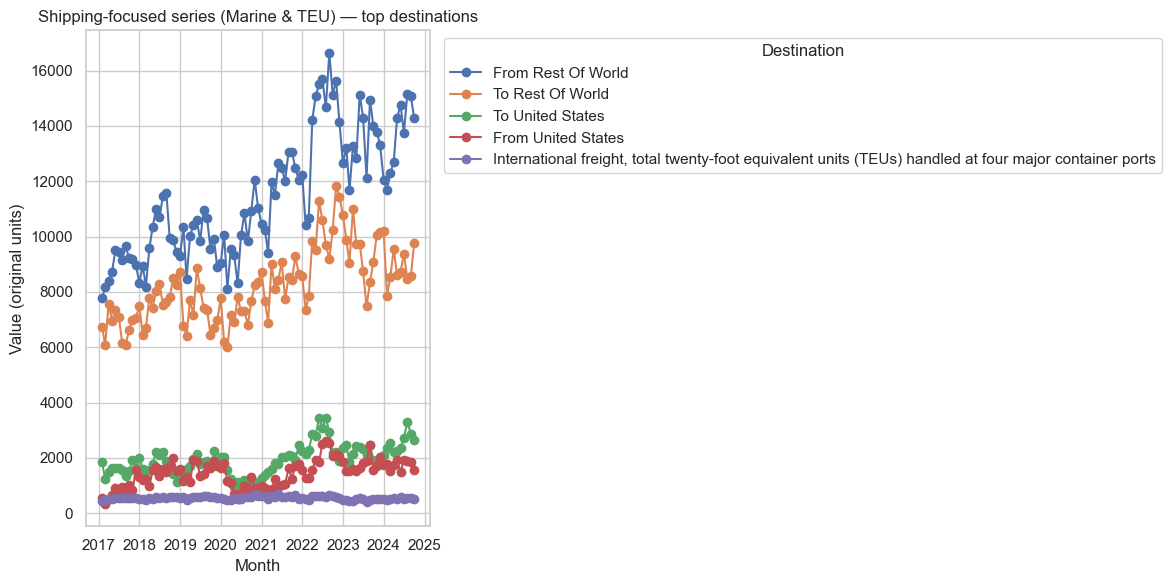

In [5]:
# Quick time-series plot: TEU & Marine by destination (top destinations)
# Select top destinations by total VALUE
top_dests = (agg.groupby('destination')['VALUE'].sum().nlargest(6).index.tolist())
plot_df = agg[agg['destination'].isin(top_dests)].copy()
plt.figure(figsize=(12,6))
for dest in top_dests:
    sub = plot_df[plot_df['destination']==dest].set_index('REF_DATE').resample('M')['VALUE'].sum()
    plt.plot(sub.index, sub.values, marker='o', label=dest)
plt.legend(title='Destination', bbox_to_anchor=(1.02,1), loc='upper left')
plt.title('Shipping-focused series (Marine & TEU) — top destinations')
plt.ylabel('Value (original units)')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

In [6]:
# Interactive Plotly chart (with graceful fallback)
import plotly.express as px
import warnings
from pathlib import Path

try:
    import nbformat
    HAVE_NBFORMAT = True
except ImportError:
    HAVE_NBFORMAT = False
    warnings.warn("nbformat not found - installing recommended: pip install nbformat>=4.2.0")

# Ensure aggregated dataframe `agg` exists and REF_DATE is datetime
plotly_df = agg.copy()
plotly_df['REF_DATE'] = pd.to_datetime(plotly_df['REF_DATE'])

# Use top destinations by total VALUE to keep plot readable
top_dests = plotly_df.groupby('destination')['VALUE'].sum().nlargest(6).index.tolist()
plotly_df = plotly_df[plotly_df['destination'].isin(top_dests)].copy()

# Create the figure
fig = px.line(plotly_df, x='REF_DATE', y='VALUE', color='destination', line_dash='mode', markers=True,
              title='Shipping (Marine & TEU) — top destinations')
fig.update_layout(
    legend=dict(orientation='v', x=1.02, y=1),
    margin=dict(r=160),
    height=600,  # Slightly taller for better readability
    template='plotly_white'  # Clean template that works well for exports
)

# Always save the interactive HTML version (most compatible)
out_html = Path('shipping_plotly_topdestinations.html')
fig.write_html(str(out_html))
print(f'Saved interactive HTML to {out_html}')

# Only try to show if we have nbformat
if HAVE_NBFORMAT:
    try:
        fig.show()
    except Exception as e:
        print(f"Could not display interactive plot ({str(e)}), but HTML was saved successfully.")
else:
    print("\nTo see interactive plots in the notebook, install nbformat:")
    print("pip install nbformat>=4.2.0")
    
print("\nNote: The saved HTML file can be opened in any web browser for interactive viewing.")

Saved interactive HTML to shipping_plotly_topdestinations.html



Note: The saved HTML file can be opened in any web browser for interactive viewing.


In [7]:
# Save the shipping-focused cleaned dataset for downstream analysis
out_path = Path('shipping_focus_23100269.csv')
# Save descriptive columns only to keep the file small
df_ship[['REF_DATE','Activity indicators','mode','destination','UOM','VALUE']].to_csv(out_path, index=False)
print('Saved shipping-focused CSV to', out_path)

Saved shipping-focused CSV to shipping_focus_23100269.csv


## Notes & next steps

- We classified 'Marine' and TEU/container series as the shipping focus. All other transport modes are labeled 'Others' (kept in the full `df` but filtered out in `df_ship`).
- Destinations are preserved when explicit (To/From United States, To/From rest of world). For aggregated port TEU series we assigned 'Canada (ports total)'. Rows without explicit destinations were labeled 'Other'.
- Next steps: convert TEU-series to a common unit where appropriate, normalize by seasonality, and join trade-dollar series if you want to analyze container throughput vs. trade value. I can add example seasonal decomposition or export an analysis-ready parquet if you'd like.